In [74]:
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [75]:
from matplotlib import style
style.use('fivethirtyeight')

# Reflect Tables into SQLAlchemy ORM

In [76]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [77]:
# reflect
Base = automap_base()
Base.prepare(autoload_with=engine)
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [78]:
# See columns and datatypes in each table
inspector = inspect(engine)
for item in Base.classes.keys():
    print(f"** Table: {item} **")
    columns = inspector.get_columns(item)
    for column in columns:
        tabs = "\t\t" if len(column["name"]) < 6 else "\t"
        print(f'{column["name"]}:{tabs}{column["type"]}')
    print("")

** Table: measurement **
id:		INTEGER
station:	TEXT
date:		TEXT
prcp:		FLOAT
tobs:		FLOAT

** Table: station **
id:		INTEGER
station:	TEXT
name:		TEXT
latitude:	FLOAT
longitude:	FLOAT
elevation:	FLOAT



In [79]:
# Save references to each table
Measurement = Base.classes["measurement"]
Station = Base.classes["station"]

In [80]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [81]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [82]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_prior = dt.datetime.strptime(most_recent_date, r"%Y-%m-%d").date() - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date,
                               Measurement.prcp)\
                        .where(Measurement.date >= one_year_prior)\
                        .order_by(Measurement.date)\
                        .all()

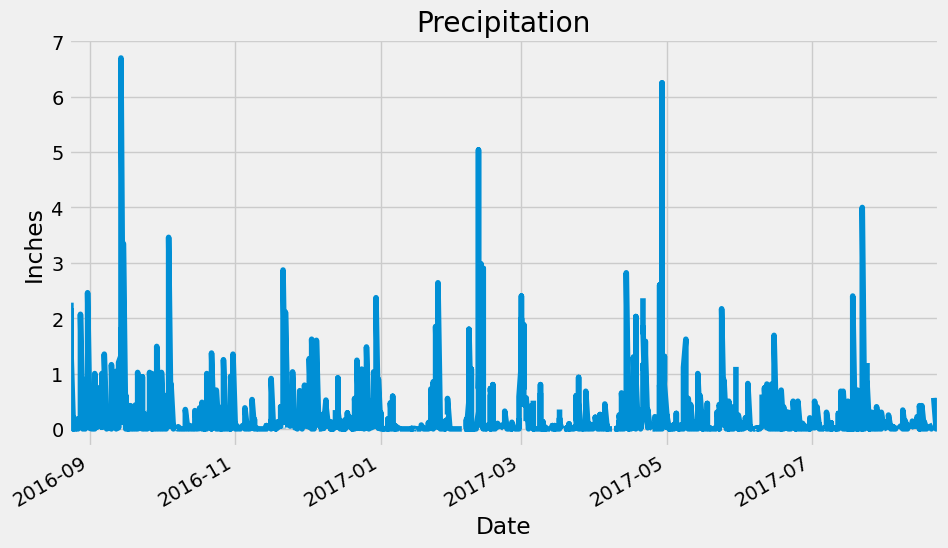

In [83]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_12_months, columns=["Date", "Precipitation"])
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"], format=r"%Y-%m-%d")

# Sort the dataframe by date
#   done in query but would be done with below:
# precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x="Date", y="Precipitation",
                      title="Precipitation", xlabel="Date", ylabel="Inches",
                      legend=False, figsize=(10, 6),
                      xlim=(one_year_prior, pd.Timestamp(most_recent_date)))
plt.show()

In [84]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [85]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).distinct().scalar()
total_stations

9

In [86]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,
                                func.count(Measurement.station).label("count"))\
                         .join(Station, Measurement.station == Station.station)\
                         .group_by(Measurement.station)\
                         .order_by(desc("count"))\
                         .all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [91]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0].station  # selecting from named tuple
most_active_data = session.query(func.min(Measurement.tobs).label("Min"),
                                 func.max(Measurement.tobs).label("Max"),
                                 func.avg(Measurement.tobs).label("Avg"))\
                           .where(Measurement.station == most_active_station)\
                           .one()
most_active_data

(54.0, 85.0, 71.66378066378067)

In [101]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
most_active_last_12_months = session.query(Measurement.tobs)\
                                    .where(Measurement.station == most_active_station,
                                           Measurement.date >= one_year_prior)\
                                    .all()
# convert list of tuples with 1 value to a list of values
most_active_station_temps = [value for (value,) in most_active_last_12_months]

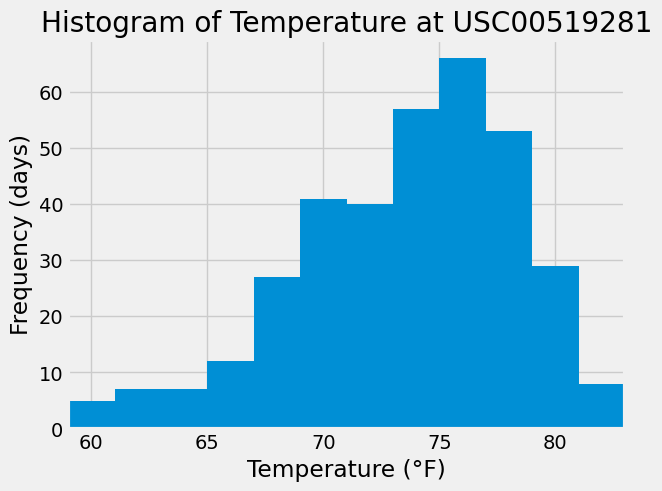

In [102]:
#  plot the results as a histogram
plt.hist(most_active_station_temps, bins=12)
plt.title(f"Histogram of Temperature at {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency (days)")
plt.xlim(59, 83)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()